<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3
Авторы материала: Юрий Кашницкий (@yorko) и Максим Уваров (@maxis42). Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 3 
## <center> Деревья решений для классификации и регрессии

**В этом задании мы разберемся с тем, как работает дерево решений в задаче регрессии, а также построим (и настроим) классифицирующие деревья решений в задаче прогнозирования сердечно-сосудистых заболеваний. 
Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1bXgaJRh4naJOGzE_Li2k50TN0kOPJdNhMtHl6H4t3Lk/edit).**

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

## 1. Простой пример восстановления регрессии с помощью дерева решений

Рассмотрим следующую одномерную задачу восстановления регрессии. Неформально, надо построить функцию $a(x)$, приближающую искомую зависимость $y = f(x)$ в терминах среднеквадратичной ошибки: $min \sum_i {(a(x_i) - f(x_i))}^2$. Подробно мы рассмотрим эту задачу в следующий раз ([4-я статья курса](https://habrahabr.ru/company/ods/blog/323890/)), а пока поговорим о том, как решать эту задачу с помощью дерева решений. Предварительно прочитайте небольшой раздел ["Дерево решений в задаче регрессии"](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy-v-zadache-regressii) 3-ей статьи курса. 

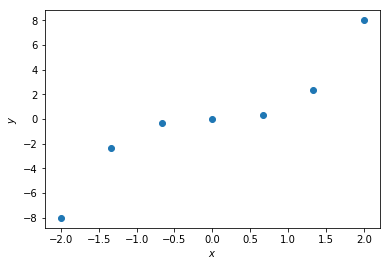

In [3]:
X = np.linspace(-2, 2, 7)
y = X ** 3

plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Проделаем несколько шагов в построении дерева решений. Исходя из соображений симметрии, выберем пороги для разбиения равными соответственно 0, 1.5 и -1.5. Напомним, что в случае задачи восстановления регрессии листовая вершина выдает среднее значение ответа по всем объектам обучающей выборки, попавшим в эту вершину.

Итак, начнём. Дерево глубины 0 состоит из одного корня, который содержит всю обучающую выборку. Как будут выглядеть предсказания данного дерева для $x \in [-2, 2]$? Постройте соответствующий график. Тут без `sklearn` – разбираемся просто с ручкой, бумажкой и Python, если надо.

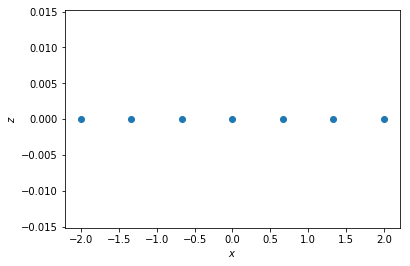

In [16]:
def f(x):
    return np.mean(y)

z_func =  np.vectorize(f)
z = z_func(X)
plt.scatter(X, z)
plt.xlabel(r'$x$')
plt.ylabel(r'$z$');

Произведем первое разбиение выборки по предикату $[x < 0]$. Получим дерево глубины 1 с двумя листьями. Постройте аналогичный график предсказаний для этого дерева.

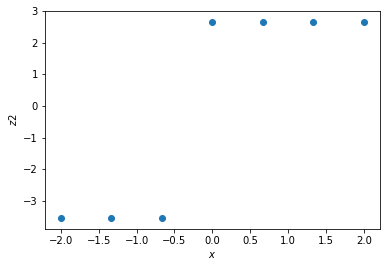

In [23]:
left = [itr for itr in y if itr < 0]
right = [itr for itr in y if itr >= 0]

def f2(x):    
    return np.mean(left) if x < 0 else np.mean(right)

z_func_2 =  np.vectorize(f2)
z2 = z_func_2(X)
plt.scatter(X, z2)
plt.xlabel(r'$x$')
plt.ylabel(r'$z2$');

В алгоритме построения дерева решений признак и значение порога, по которым происходит разбиение выборки, выбираются исходя из некоторого критерия. Для регрессии обычно используется дисперсионный критерий:
$$Q(X, j, t) = D(X) - \dfrac{|X_l|}{|X|} D(X_l) - \dfrac{|X_r|}{|X|} D(X_r),$$
где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[x_j < t]$ (то есть по $j$-ому признаку и порогу $t$), $|X|$, $|X_l|$, $|X_r|$ - размеры соответствующих выборок, а $D(X)$ – дисперсия ответов на выборке $X$:
$$D(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j – \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2,$$
где $y_i = y(x_i)$ – ответ на объекте $x_i$. При каждом разбиении вершины выбираются признак $j$ и значение порога $t$, максимизирующие значение функционала $Q(X, j, t)$.

В нашем случае признак всего один, поэтому $Q$ зависит только от значения порога $t$ (и ответов выборки в данной вершине). 

Постройте график функции $Q(X, t)$ в корне в зависимости от значения порога $t$ на отрезке $[-1.9, 1.9]$.

In [46]:
def D(y):    
    mean = np.mean(y)
    
    d = [(itr - mean) *(itr - mean) for itr in y]
    return np.mean(d)

def regression_var_criterion(X, y, t):
    left_y = []
    right_y = []
    
    cardinality_X = len(X)   
    
    for i in range(len(X)):
        if(X[i] < t):            
            left_y.append(y[i])
        else:            
            right_y.append(y[i])
    
    cardinality_left_X = len(left_y)
    cardinality_right_X = len(right_y)
    
    d = D(y)
    d_l = D(left_y)
    d_r = D(right_y)
    
    return d - cardinality_left_X/ cardinality_X * d_l - cardinality_right_X/ cardinality_X * d_r    

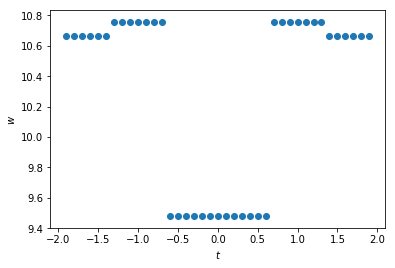

In [47]:
w = [regression_var_criterion(X, y, (-19 + t) * 0.1) for t in range(39)]


plt.scatter([ (-19 + t) * 0.1 for t in range(39)], w)
plt.xlabel(r'$t$')
plt.ylabel(r'$w$');
    

**<font color='red'>Вопрос 1.</font> Оптимально ли с точки зрения дисперсионного критерия выбранное нами значение порога $t = 0$?**
- Да
- Нет

Теперь произведем разбиение в каждой из листовых вершин. В левой (соответствующей ветви $x < 0$) – по предикату $[x < -1.5]$, а в правой (соответствующей ветви $x \geqslant 0$) – по предикату $[x < 1.5]$. Получится дерево глубины 2 с 7 вершинами и 4 листьями. Постройте график предсказаний этого дерева для $x \in [-2, 2]$.

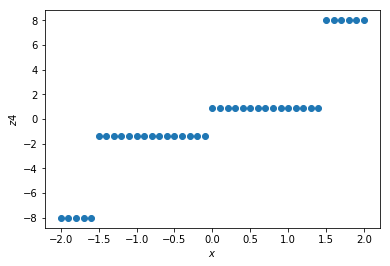

In [58]:
y_0m15 = np.mean([itr**3 for itr in X if itr <-1.5])
y_m150 = np.mean([itr**3 for itr in X if itr >=-1.5 and itr < 0])
y_015 = np.mean([itr**3 for itr in X if itr >=0 and itr < 1.5])
y_15 = np.mean([itr**3 for itr in X if itr >= 1.5])

def f4(x):
    if x < -1.5:
        return y_0m15
    else: 
        if x < 0:
            return y_m150
        else: 
            if x < 1.5:
                return y_015
            else: 
                return y_15


buf_x = [-2 + itr * 0.1 for  itr in range(41)]
z_func_4 =  np.vectorize(f4)
z4 = z_func_4(buf_x)

plt.scatter(buf_x, z4)
plt.xlabel(r'$x$')
plt.ylabel(r'$z4$');




**<font color='red'>Вопрос 2.</font> Из какого числа отрезков состоит график (необходимо считать как горизонтальные, так и вертикальные прямые), изображающий предсказания построенного дерева на отрезке [-2, 2]?**
- 5
- 6
- 7
- 8

## 2. Построение дерева решений для прогноза сердечно-сосудистых заболеваний
Считаем в `DataFrame` знакомый нам набор данных по сердечно-сосудистым заболеваниям. 

In [59]:
df = pd.read_csv('../../data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [60]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Сделайте небольшие преобразования признаков: постройте признак "возраст в годах" (полных лет), а также постройте по 3 бинарных признака на основе `cholesterol` и `gluc`, где они, соответственно, равны 1, 2 или 3. Эта техника называется dummy-кодированием или One Hot Encoding (OHE), удобней всего в данном случае использовать `pandas.get_dummmies`. Исходные признаки `cholesterol` и `gluc` после кодирования использовать не нужно.

In [109]:
df["age_years"] = df["age"] / 365.26

dumm_gl= pd.get_dummies(df["gluc"])

df["gluc_1"] = dumm_gl[1]
df["gluc_2"] = dumm_gl[2]
df["gluc_3"] = dumm_gl[3]

dumm_chol = pd.get_dummies(df["cholesterol"])
df["chol_1"] = dumm_chol[1]
df["chol_2"] = dumm_chol[2]
df["chol_3"] = dumm_chol[3]

y_data = df["cardio"]

dec_data  = df.copy()
dec_data = dec_data.drop(columns=["age", "cholesterol", "gluc", "cardio"])


dec_data.columns.tolist() 





['gender',
 'height',
 'weight',
 'ap_hi',
 'ap_lo',
 'smoke',
 'alco',
 'active',
 'age_years',
 'gluc_1',
 'gluc_2',
 'gluc_3',
 'chol_1',
 'chol_2',
 'chol_3']

Разбейте выборку на обучающую и отложенную (holdout) части в пропорции 7/3. Для этого используйте метод `sklearn.model_selection.train_test_split`, зафиксируйте у него `random_state`=17.

In [94]:
X_train, X_valid, y_train, y_valid = train_test_split(dec_data.values, y_data, test_size=0.3,random_state=17)

In [207]:
y_train

id
30908    1
86475    1
77291    1
63162    1
43647    0
43357    0
8204     0
32488    1
47958    0
15620    0
93627    0
63891    0
25009    1
63233    1
89222    1
59329    1
25803    1
77963    0
58831    0
37440    0
8397     1
29347    0
97075    1
92911    0
58451    0
80780    1
26990    0
12391    1
89415    0
62689    1
        ..
18083    1
22018    1
82997    1
99864    1
27132    1
57997    1
80252    0
98080    1
7278     0
97714    1
49773    1
76586    0
58859    1
88051    1
4720     0
84843    0
96198    1
10453    0
70117    0
81584    0
76655    1
27440    0
78417    1
2507     1
66530    1
53319    1
36581    1
60428    0
49936    0
92425    0
Name: cardio, Length: 49000, dtype: int64

Обучите на выборке `(X_train, y_train)` дерево решений с ограничением на максимальную глубину в 3. Зафиксируйте у дерева `random_state=17`. Визуализируйте дерево с помошью `sklearn.tree.export_graphviz`, `dot` и `pydot`. Пример дан в [статье](https://habrahabr.ru/company/ods/blog/322534/) под спойлером "Код для отрисовки дерева". Названия файлов писать без кавычек, для того чтобы работало в jupyter notebook. Обратите внимание, что команды в Jupyter notebook, начинающиеся с восклицательного знака – это терминальные команды (которые мы обычно запускаем в терминале/командной строке).

In [111]:
tree = DecisionTreeClassifier(max_depth=3, random_state=17)
tree.fit(X_train, y_train)
export_graphviz(tree,feature_names=dec_data.columns.tolist() , 
out_file='../../img/MyImgs/avg_first_tree.dot', filled=True)
!dot -Tpng '../../img/MyImgs/avg_first_tree.dot' -o '../../img/MyImgs/avg_first_tree.png'

**<font color='red'>Вопрос 3.</font> Какие 3 признака задействуются при прогнозе в построенном дереве решений? (то есть эти три признака "можно найти в дереве")**
- weight, height, gluc=3
- smoke, age, gluc=3
- age, weight, chol=3
- age, ap_hi, chol=3

Сделайте с помощью обученного дерева прогноз для отложенной выборки `(X_valid, y_valid)`. Посчитайте долю верных ответов (accuracy).

In [125]:
tree_pred = tree.predict(X_valid)
acc1 = accuracy_score(y_valid, tree_pred)
acc1

0.7212857142857143

Теперь на кросс-валидации по выборке  `(X_train, y_train)`  настройте глубину дерева, чтобы повысить качество модели. Используйте GridSearchCV, 5-кратную кросс-валидацию. Зафиксируйте у дерева `random_state`=17. Перебирайте параметр `max_depth` от 2 до 10. 

In [113]:
tree_params = {'max_depth': list(range(2, 11))}

tree_grid = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, verbose=True)

Нарисуйте график того, как меняется средняя доля верных ответов на кросс-валидации в зависимости от значения `max_depth`.

In [115]:
tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.3s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=True)

Выведите лучшее значение `max_depth`, то есть такое, при котором среднее значение метрики качества на кросс-валидации максимально. Посчитайте также, какова теперь доля верных ответов на отложенной выборке. Все это можно сделать с помощью обученного экземпляра класса `GridSearchCV`.

In [119]:
tree_grid.best_params_

{'max_depth': 6}

In [120]:
tree_grid.best_score_

0.7319591836734693

In [159]:
tree_grid.cv_results_["split4_train_score"]

array([0.71398689, 0.72607842, 0.72903752, 0.73197112, 0.73332313,
       0.73760873, 0.74227698, 0.74860335, 0.75773577])

In [164]:
acc2 = accuracy_score(y_valid, tree_grid.predict(X_valid))
acc2

0.7258095238095238

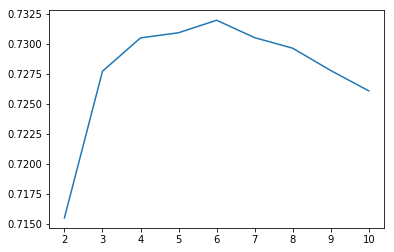

In [174]:
p_d_x = range(2,11,1)

# for itr in tree_grid.cv_results_["mean_test_score"]:
#     plot_data.append([k, itr])
#     k=k+1

plt.plot(p_d_x,tree_grid.cv_results_["mean_test_score"])
plt.show()

In [175]:
(acc2-acc1)/acc1*100

0.6271869016967002

**<font color='red'>Вопрос 4.</font> Имеется ли на кривой валидации по максимальной глубине дерева пик `accuracy`, если перебирать `max_depth` от 2 до 10? Повысила ли настройка глубины дерева качество классификации (accuracy) более чем на 1% на отложенной выборке (надо посмотреть на выражение (acc2 - acc1) / acc1 * 100%, где acc1 и acc2 – доли верных ответов на отложенной выборке до и после настройки max_depth соответственно)?**
- да, да
- да, нет
- нет, да
- нет, нет

Обратимся опять (как и в 1 домашке) к картинке, демонстрирующей шкалу SCORE для расчёта риска смерти от сердечно-сосудистого заболевания в ближайшие 10 лет.
<img src='../../img/SCORE2007.png' width=70%>

Создайте бинарные признаки, примерно соответствующие этой картинке:
- $age \in [45,50), \ldots age \in [60,65) $ (4 признака)
- верхнее артериальное давление: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 признака)

Если значение возраста или артериального давления не попадает ни в один из интервалов, то все бинарные признаки будут равны нулю. Далее будем строить дерево решений с этим признаками, а также с признаками ``smoke``, ``cholesterol``  и ``gender``. Из признака ``cholesterol`` надо сделать 3 бинарных, соотв-х уникальным значениям признака ( ``cholesterol``=1,  ``cholesterol``=2 и  ``cholesterol``=3), эта техника называется dummy-кодированием или One Hot Encoding (OHE). Признак ``gender`` надо перекодировать: значения 1 и 2 отобразить на 0 и 1. Признак лучше переименовать в ``male`` (0 – женщина, 1 – мужчина). В общем случае кодирование значений делает ``sklearn.preprocessing.LabelEncoder``, но в данном случае легко обойтись и без него.

Итак, дерево решений строится на 12 бинарных признаках (исходные признаки не берем).

Постройте дерево решений с ограничением на максимальную глубину = 3 и обучите его на всей исходной обучающей выборке. Используйте `DecisionTreeClassifier`, на всякий случай зафикисровав `random_state=17`, остальные аргументы (помимо `max_depth` и `random_state`) оставьте по умолчанию. 

**<font color='red'>Вопрос 5.</font> Какой бинарный признак из 12 перечисленных оказался самым важным для обнаружения ССЗ, то есть поместился в вершину построенного дерева решений?**
- Верхнее артериальное давление от 160 до 180 (мм рт.ст.)
- Пол мужской / женский
- Верхнее артериальное давление от 140 до 160 (мм рт.ст.)
- Возраст от 50 до 55 (лет)
- Курит / не курит
- Возраст от 60 до 65 (лет)

In [200]:
def age_split(row, min, max):
    if row['age_years'] < min or row['age_years'] >= max:
        return 0    
    return 1

def ap_hi_split(row, min, max):
    if row["ap_hi"] < min or row["ap_hi"] >= max:
        return 0
    return 1

def male(row):
    if row["gender"] == 1:
        return 0
    return 1
    
    

df["age_yaer_45_50"] = df.apply(lambda row: age_split(row, 45,50), axis=1) 
df["age_yaer_50_55"] = df.apply(lambda row: age_split(row, 50,55), axis=1) 
df["age_yaer_55_60"] = df.apply(lambda row: age_split(row, 55,60), axis=1) 
df["age_yaer_60_65"] = df.apply(lambda row: age_split(row, 60,65), axis=1) 

df["ap_hi_120_140"] = df.apply(lambda row: ap_hi_split(row, 120,140), axis=1) 
df["ap_hi_140_160"] = df.apply(lambda row: ap_hi_split(row, 140,160), axis=1) 
df["ap_hi_160_180"] = df.apply(lambda row: ap_hi_split(row, 160,180), axis=1) 

df["male"] = df.apply(lambda row: male(row), axis=1) 

for_tree_data = pd.DataFrame()
for_tree_data["male"] = df["male"]
for_tree_data["smoke"] = df["smoke"]

for_tree_data["age_yaer_45_50"] = df["age_yaer_45_50"]
for_tree_data["age_yaer_50_55"] = df["age_yaer_50_55"]
for_tree_data["age_yaer_55_60"] = df["age_yaer_55_60"]
for_tree_data["age_yaer_60_65"] = df["age_yaer_60_65"]

for_tree_data["ap_hi_120_140"] = df["ap_hi_120_140"]
for_tree_data["ap_hi_140_160"] = df["ap_hi_140_160"]
for_tree_data["ap_hi_160_180"] = df["ap_hi_160_180"]

for_tree_data["chol_1"] = df["chol_1"]
for_tree_data["chol_2"] = df["chol_2"]
for_tree_data["chol_3"] = df["chol_3"]

for_tree_data.head()

,male,smoke,age_yaer_45_50,age_yaer_50_55,age_yaer_55_60,age_yaer_60_65,ap_hi_120_140,ap_hi_140_160,ap_hi_160_180,chol_1,chol_2,chol_3
id,,,,,,,,,,,,
0,1,0,0,1,0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0,1,0,0,0,1
2,0,0,0,1,0,0,1,0,0,0,0,1
3,1,0,1,0,0,0,0,1,0,1,0,0
4,0,0,1,0,0,0,0,0,0,1,0,0


In [210]:
for_tree_y_data = df["cardio"]
for_tree_x_data = for_tree_data.values

tree_f = DecisionTreeClassifier(max_depth=3, random_state=17)
tree_f.fit(for_tree_x_data, for_tree_y_data)

export_graphviz(tree_f,feature_names=for_tree_data.columns.tolist() , 
out_file='../../img/MyImgs/avg_first_tree_final.dot', filled=True)
!dot -Tpng '../../img/MyImgs/avg_first_tree_final.dot' -o '../../img/MyImgs/avg_first_tree_final.png'
